# Final Project Explainable AI

In [253]:
# For the classifier
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from accelerate import init_empty_weights
import numpy as np
from sklearn.metrics import accuracy_score

In [251]:
# For LIME
from lime.lime_text import LimeTextExplainer

In [252]:
# For the attention-based method
import torch
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

I am using the IMDB dataset, which consists of movie reviews. It contains 50000 records, divided into 25000 for training and 25000 for testing. The records have an according label, which indicates of the review is positive or negative. The dataset can be found here: https://www.kaggle.com/code/trentpark/data-analysis-basics-imdb-dataset

In [2]:
# Load IMDB dataset 
dataset = load_dataset("imdb")

In [3]:
train_data = dataset["train"]
test_data = dataset["test"]

The classification model used is a DistilBERT model pretrained on the IMDB dataset. For more information see https://huggingface.co/textattack/distilbert-base-uncased-imdb.

In [5]:
model_name = "textattack/distilbert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

C:\Users\maasl\anaconda3\envs\XAI\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The Bert model doesnt take inputs longer than 512 characters, so we will truncate reviews which are longer than 512 words.

In [19]:
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    truncation=True,        #truncate long reviews to 512 tokens
    max_length=512,         
    return_all_scores=False
)



C:\Users\maasl\anaconda3\envs\XAI\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


We take only a subset because the model is already trained, and the explanation methods only look at single instances. Taking the entire dataset would be too computationally heavy and time would be lost.

In [61]:
# Randomly sample from test data with fixed seed for reproducability
np.random.seed(42)

# We are using a sample of 300 to get an estimate of the model's accuracy
indices = np.random.choice(len(dataset["test"]), size=300, replace = False)
subset = dataset["test"].select(indices)

texts = [example['text'] for example in subset]
true_labels = [example['label'] for example in subset]  # 0 = neg, 1 = pos

# print(len(texts), len(true_labels))

In [62]:
# Predict using the classifier
predictions = classifier(texts)

In [87]:
print(classifier("This movie was absolutely terrible. I hated it"))
print(classifier("This was one of the best films I have ever seen"))
print(predictions[5]['label'])

[{'label': 'LABEL_0', 'score': 0.998586893081665}]
[{'label': 'LABEL_1', 'score': 0.9978604912757874}]
LABEL_0


We take a random subset of 300 predictions to get a general idea of how accurate the model is

In [125]:
# Convert model predictions POSITIVE/NEGATIVE to 1/0
predicted_labels = [1 if p["label"] == "LABEL_1" else 0 for p in predictions]

# Estimate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy on 300 random IMDB test samples: {accuracy:.2f}")

Accuracy on 300 random IMDB test samples: 0.91


Although only on 300 samples, we can see that with an accuracy of 0.91 definitely performs better than chance, so everything is working properly

## Lime explainer

The Hugging Face pipeline only returns the predicted label and its probability, while lime wants class probabilities for all classes for each instance. Furthermore, LIME needs a function that can process all the perturbated inputs. We thus have to create a wrapper function. 

In [157]:
def predict_proba(text):
    outputs = classifier(text)
    print("output:", outputs)
    return np.array([
        [1 - pred['score'], pred['score']] if pred['label'] == "LABEL_1"
        else [pred['score'], 1 - pred['score']]
        for pred in outputs
    ])

In [254]:
# Converting to probability input which lime can process
# print(texts[0])

# # outputs = classifier(texts)
# print(texts[10])
# print(classifier(texts[10]))
# print(type(classifier(texts[10])))
# print(classifier(texts[10])[0]['label'])
# print(predict_proba(texts[10]))

In [255]:
# Initiating explainer with display-purpose class names
explainer = LimeTextExplainer(class_names = ["Negative", "Positive"])


In [160]:
example_1 = texts[10]
# print(example_1)

explanation = explainer.explain_instance(
    text_instance=example_1,
    classifier_fn=predict_proba,
    num_features=10,
    top_labels=1, 
    num_samples = 5000)



output: [{'label': 'LABEL_1', 'score': 0.9950284361839294}, {'label': 'LABEL_1', 'score': 0.8784592151641846}, {'label': 'LABEL_1', 'score': 0.7542014718055725}, {'label': 'LABEL_1', 'score': 0.998704195022583}, {'label': 'LABEL_1', 'score': 0.9972924590110779}, {'label': 'LABEL_1', 'score': 0.7667728066444397}, {'label': 'LABEL_1', 'score': 0.992643415927887}, {'label': 'LABEL_1', 'score': 0.993509829044342}, {'label': 'LABEL_1', 'score': 0.5263844728469849}, {'label': 'LABEL_1', 'score': 0.9937829375267029}, {'label': 'LABEL_1', 'score': 0.5740289092063904}, {'label': 'LABEL_0', 'score': 0.9955279231071472}, {'label': 'LABEL_1', 'score': 0.992771565914154}, {'label': 'LABEL_1', 'score': 0.9376220107078552}, {'label': 'LABEL_1', 'score': 0.9858630299568176}, {'label': 'LABEL_1', 'score': 0.9956071972846985}, {'label': 'LABEL_0', 'score': 0.9051880836486816}, {'label': 'LABEL_1', 'score': 0.9855588674545288}, {'label': 'LABEL_1', 'score': 0.8638686537742615}, {'label': 'LABEL_1', 'scor

In [162]:
explanation.show_in_notebook(text=True)

In the example above, we can see a positive review. The 10 most influential words that LIME finds are shown. We can see that words like 'funny', 'very', 'best' contribute positively to the prediction (that it's positive). Words like 'horrible' and 'fell' contribute negatively.

Negative example

In [166]:
example_2 = texts[5]
print(example_2)

explanation = explainer.explain_instance(
    text_instance=example_2,
    classifier_fn=predict_proba,
    num_features=10,
    top_labels=1, 
    num_samples = 5000)

I thought this was an extremely bad movie. The whole time I was watching this movie I couldn't help but think over and over how bad it is, and how that was $3.69 down the drain. The plot was so jumpy. They did an excellent job at the beginning of explaining who dated who in high school, but they never really explained anything after that. Was it a supernatural thriller? Was it a regular thriller? Apparently you can decide for yourself, because they didn't see the need to explain. I understood basically what happened, I think. What I got confused about was all of it prior, what was the deal with the bloody noses, phone calls, etc.? Was this guy coming back? Was the wife channeling "Carrie" or something? Who knows? You certainly won't after watching this movie.
output: [{'label': 'LABEL_0', 'score': 0.9984620809555054}, {'label': 'LABEL_0', 'score': 0.9984038472175598}, {'label': 'LABEL_0', 'score': 0.9875916242599487}, {'label': 'LABEL_0', 'score': 0.997617781162262}, {'label': 'LABEL_0

In [168]:
explanation.show_in_notebook(text=True)

In the example above we can see a negative review. LIME mainly highlights words like bad and jumpy. 

## Attention-based methods

BERT models use multi-head self-attention. Each attention head produces a matrix, which shows how much each token pays attention to other tokens. Inspecting these outputs, we can derive which tokens the model focussed the most on. 

In [171]:
# Create a new model that outputs the attention weights
model_attention = AutoModelForSequenceClassification.from_pretrained(
    model_name, output_attentions = True
)
# The tokenizer stays the same

# Put model in eval mode
model_attention.eval()

C:\Users\maasl\anaconda3\envs\XAI\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Computing the attention weights for the first example.

In [180]:

inputs1 = tokenizer(example_1, return_tensors = "pt", truncation = True)

with torch.no_grad():
    outputs = model_attention(**inputs1)  # extracting
    attentions = outputs.attentions

In [200]:
print(type(attentions))
print(len(attentions))
print(attentions[5].shape)
# print(inputs1)

<class 'tuple'>
6
torch.Size([1, 12, 196, 196])


We get a tuple with a length of 6, which means the DistilBERT model has 6 layers. To inspect the attention, we will use the last layer's weights, because this gives us the explanation of the decisions the model made. We will look at the attention of the [CLS] token, which is a special token added to the beginning of input text by BERT models. It acts as a summary.

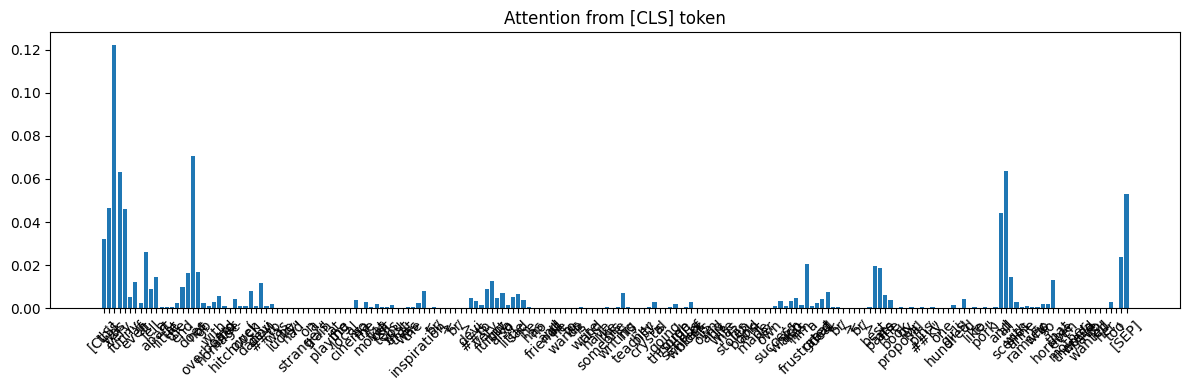

In [204]:
# Grabbing the last attention tuple
last_att = attentions[-1][0]  # --> shape (12, 196, 196)

# Averaging the attention over all 12 heads.
avg_att = last_att.mean(dim = 0)  # --> shape (196,196)

cls_attn = avg_att[0]                  # --> shape (196,)
tokens = tokenizer.convert_ids_to_tokens(inputs1['input_ids'][0])

# Plot
plt.figure(figsize=(12, 4))
plt.bar(range(len(tokens)), cls_attn)
plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.title("Attention from [CLS] token")
plt.tight_layout()
plt.show()

As we can see, there is too many words, so let's create a function where we can control the amount of tokens plotted.

In [242]:
def plot_topk_cls(text, model, tokenizer, k=20):
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    # Forward pass with attention output
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    last_attn = outputs.attentions[-1][0]    # Get attentions from last layer
    avg_attn = last_attn.mean(dim=0)       # Average over all 12 heads
    cls_attn = avg_attn[0]                 # attention from [CLS] token 

    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Get top-k token indices excluding CLS 
    topk_id = torch.topk(cls_attn[1:], k=k).indices + 1
    topk_scores = cls_attn[topk_id]
    topk_tokens = [tokens[i] for i in topk_id]

    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(k), topk_scores.tolist())
    plt.yticks(range(k), topk_tokens)
    plt.gca().invert_yaxis()
    plt.xlabel("Attention from CLS token")
    plt.title(f"Top {k} Most Attended Tokens")
    plt.tight_layout()
    plt.show()

This was very funny, even if it fell apart a little at the end. Does not go overboard with homage after to Hitchcock - Owen (Danny DeVito) was lucky he had "Strangers on A Train" playing at the local cinema, so the movie flat out tells you that that was the inspiration. <br /><br />DeVito is very funny but also a little sad. He has no friends and all he wants to do is write and have someone like his writing. His teacher, Billy Crystal, is going through some serious writers block of his own and his wife has stolen his book and made it her own success, which also has him frustrated a great deal.<br /><br />Best parts are the book proposal by Mr. Pinsky ("One Hundred Girls I'd Like to Pork") and all scenes with Anne Ramsey, who is so horrible that even Mother Theresa would have wanted to kill her, too!


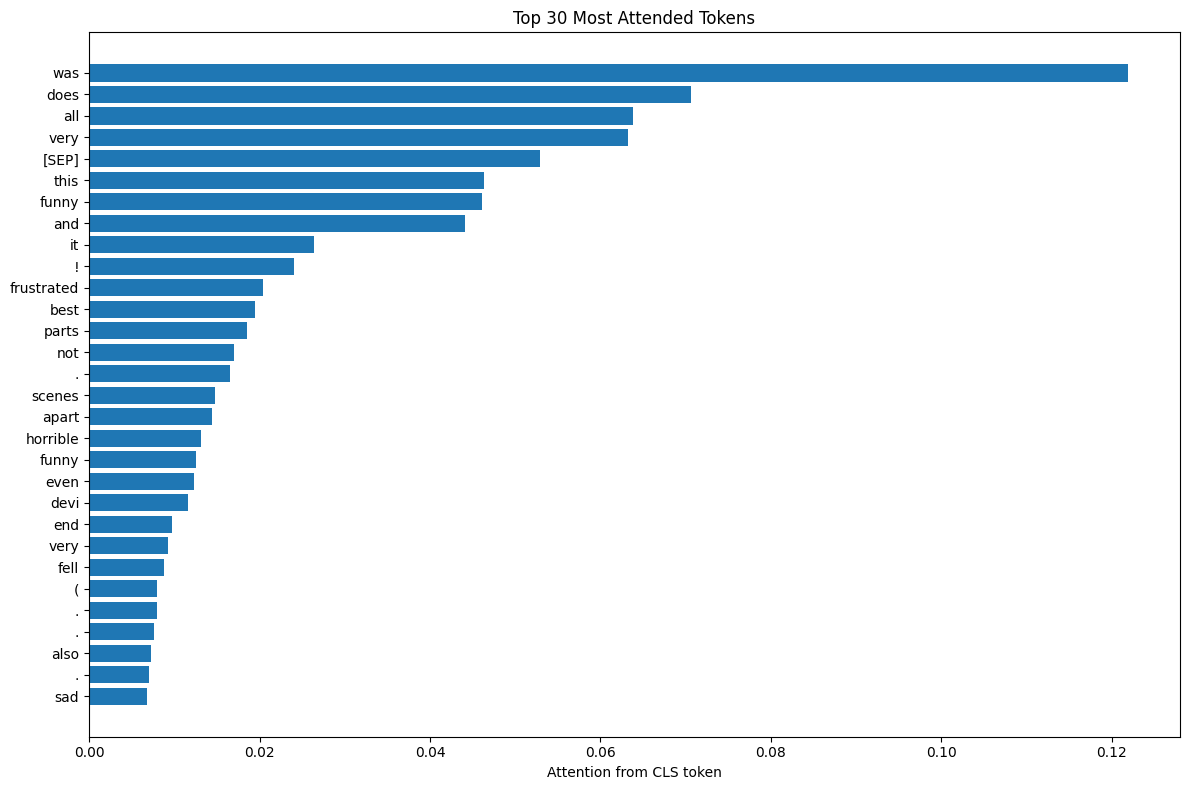

In [243]:
print(example_1)
plot_topk_cls(example_1, model_attention, tokenizer, k = 30)

### Making an attention heatmap

Creating a function to extract again the top-k tokens based on [CLS], include only those tokens in the attention matrix, then showing the k by k heatmap, which shows how these tokens pay attention to eachother.

In [244]:
def plot_cls_heatmap(text, model, tokenizer, k = 30):
    # Tokenize the input
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    # Forward pass with attention output
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    last_attn = outputs.attentions[-1][0]    # Get attentions from last layer
    avg_attn = last_attn.mean(dim=0)       # Average over all 12 heads
    cls_attn = avg_attn[0]                 # attention from [CLS] token 

    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])   

    # excluding [CLS]
    topk_ids = torch.topk(cls_attn[1:], k=min(k, len(cls_attn) - 1)).indices + 1

    # Sorting so it's easier to only extract the top k tokens
    topk_ids = topk_ids.sort().values

    topk_tokens = [tokens[i] for i in topk_ids]
    matrix = avg_attn[topk_ids][:, topk_ids]

    # Plotting heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(matrix.numpy(), xticklabels = topk_tokens, yticklabels = topk_tokens)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Mutual attention beweteen top{k} tokens")
    plt.tight_layout()
    plt.show()

This was very funny, even if it fell apart a little at the end. Does not go overboard with homage after to Hitchcock - Owen (Danny DeVito) was lucky he had "Strangers on A Train" playing at the local cinema, so the movie flat out tells you that that was the inspiration. <br /><br />DeVito is very funny but also a little sad. He has no friends and all he wants to do is write and have someone like his writing. His teacher, Billy Crystal, is going through some serious writers block of his own and his wife has stolen his book and made it her own success, which also has him frustrated a great deal.<br /><br />Best parts are the book proposal by Mr. Pinsky ("One Hundred Girls I'd Like to Pork") and all scenes with Anne Ramsey, who is so horrible that even Mother Theresa would have wanted to kill her, too!


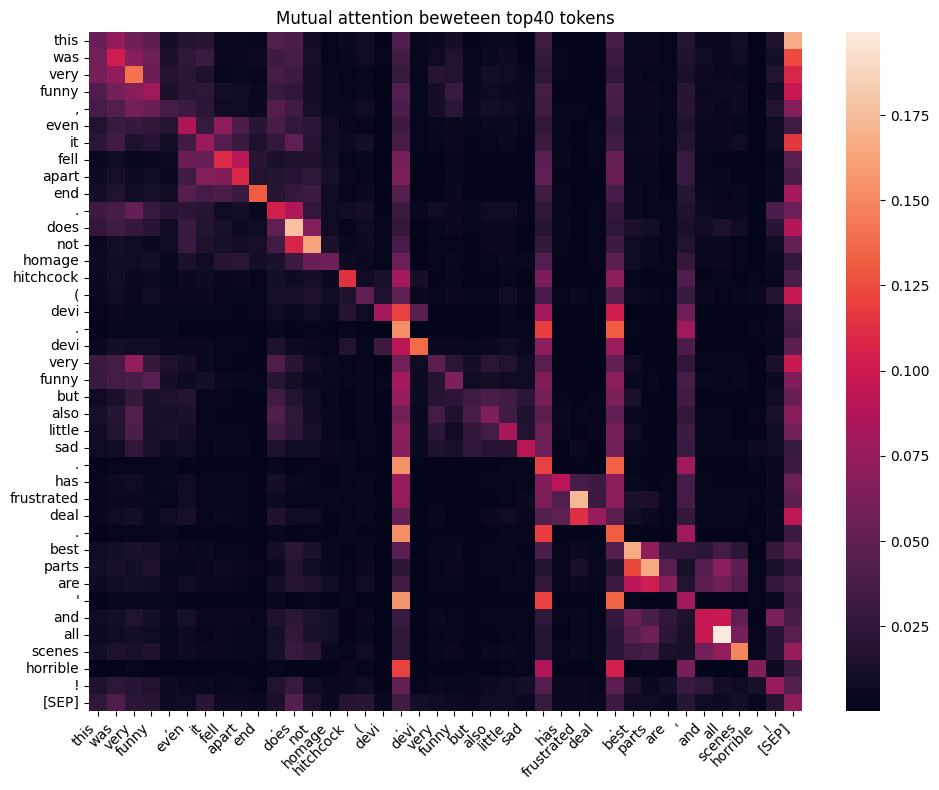

In [245]:
print(example_1)
plot_cls_heatmap(example_1, model_attention, tokenizer, k = 40)

Above can be seen how words that are grouped together and are more related, tend to 'pay' more attention to eachother in the model. 

Now let's do the same for the second example

I thought this was an extremely bad movie. The whole time I was watching this movie I couldn't help but think over and over how bad it is, and how that was $3.69 down the drain. The plot was so jumpy. They did an excellent job at the beginning of explaining who dated who in high school, but they never really explained anything after that. Was it a supernatural thriller? Was it a regular thriller? Apparently you can decide for yourself, because they didn't see the need to explain. I understood basically what happened, I think. What I got confused about was all of it prior, what was the deal with the bloody noses, phone calls, etc.? Was this guy coming back? Was the wife channeling "Carrie" or something? Who knows? You certainly won't after watching this movie.


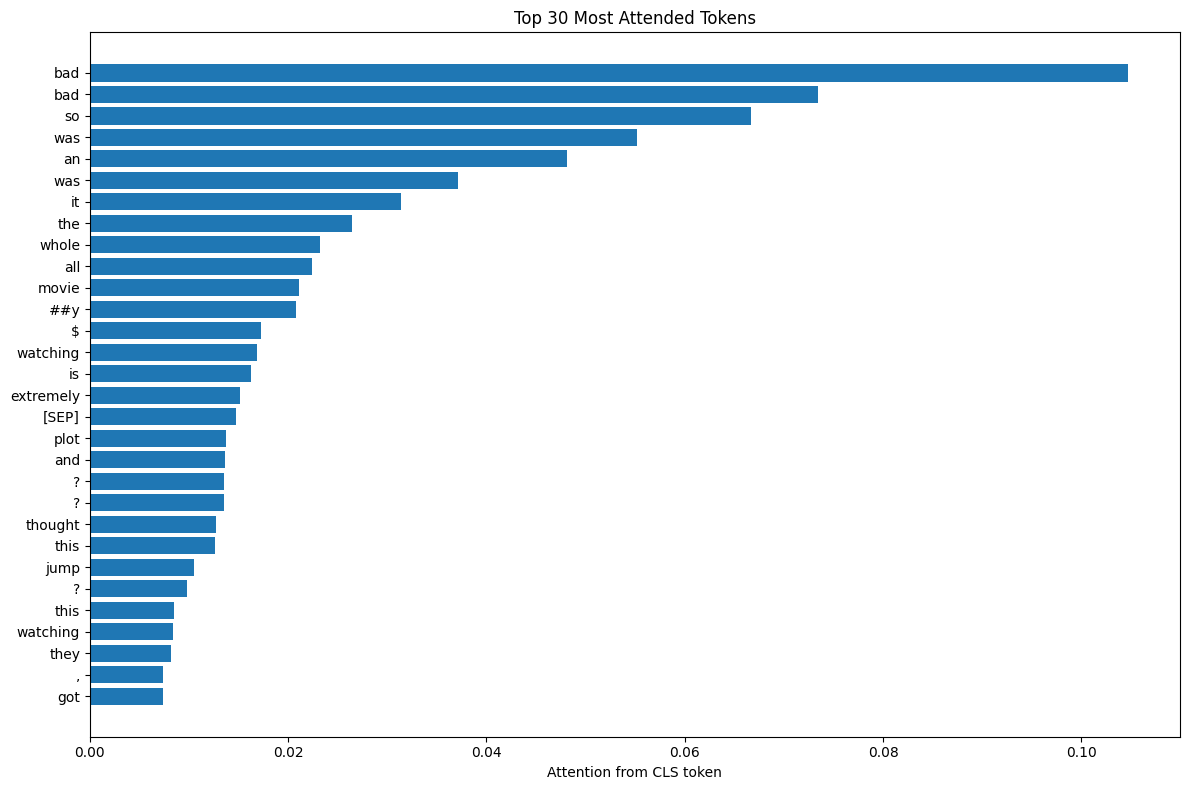

In [241]:
print(example_2)
plot_topk_cls(example_2, model_attention, tokenizer, k = 30)

Since this is a negative review, most attention goes to the words 'bad', which makes a lot of sense.

I thought this was an extremely bad movie. The whole time I was watching this movie I couldn't help but think over and over how bad it is, and how that was $3.69 down the drain. The plot was so jumpy. They did an excellent job at the beginning of explaining who dated who in high school, but they never really explained anything after that. Was it a supernatural thriller? Was it a regular thriller? Apparently you can decide for yourself, because they didn't see the need to explain. I understood basically what happened, I think. What I got confused about was all of it prior, what was the deal with the bloody noses, phone calls, etc.? Was this guy coming back? Was the wife channeling "Carrie" or something? Who knows? You certainly won't after watching this movie.


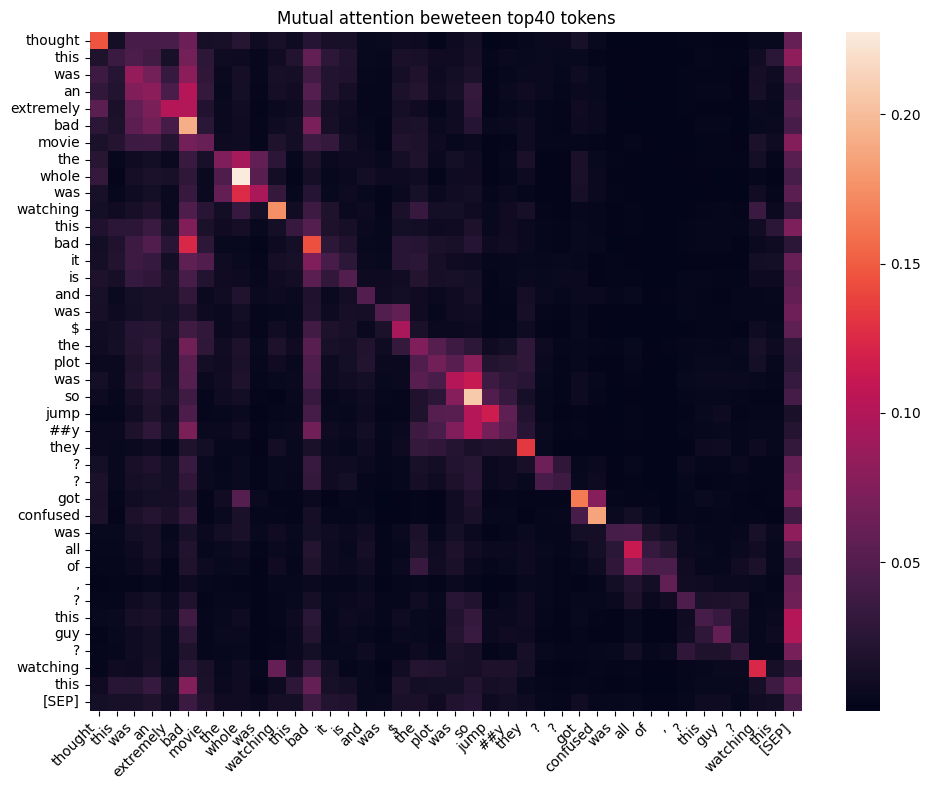

In [231]:
print(example_2)
plot_cls_heatmap(example_2, model_attention, tokenizer, k=40)

Again, related words pay more attention to eachother.

## Extra Examples

In [262]:
print(texts[30])
print("\n")
print(texts[250])

Now, the sci-fi channel original company has made some pretty crappy films (House of the dead 2, All souls day, etc.) but when you leave the job entirely to horror master actor/writer and now director, Bruce Campbell, you get one of the best damn made for TV independent horror films ever made! I normally hate these movies, in my previous review, House of the dead 2, I could not believe how horrible the film was! But somehow I took a liking for this film, a very good liking for this film. The violence is good and so is the black comedy in the film and I recommend you get it, a true Bruce Campbell masterpiece! Well, since there is only a few more lines left I can say whatever I want about this movie: IJAJKASIF JHJDJ NXD FNEHSD FHNCFNFVHS DJKEALJWSNS.UHHD SISHSNHF AHCNAKDJH HNDCHJNDNH JACND HCHJNNHW JHJ NASHDNFHCKA FHNKHAD SAKASDADJ FJKDFA


i have to admit thanks to this movie i'm now afraid of mannequins. hahaha.<br /><br />but yes, first off the acting in this movie at least by my stan

In [263]:
extra_explanation1 = explainer.explain_instance(
    text_instance=texts[30],
    classifier_fn=predict_proba,
    num_features=10,
    top_labels=1, 
    num_samples = 2500)

output: [{'label': 'LABEL_1', 'score': 0.9971339702606201}, {'label': 'LABEL_1', 'score': 0.9974368214607239}, {'label': 'LABEL_1', 'score': 0.9733698964118958}, {'label': 'LABEL_1', 'score': 0.963459312915802}, {'label': 'LABEL_1', 'score': 0.9692395329475403}, {'label': 'LABEL_1', 'score': 0.8762562870979309}, {'label': 'LABEL_0', 'score': 0.6425456404685974}, {'label': 'LABEL_1', 'score': 0.9806817770004272}, {'label': 'LABEL_1', 'score': 0.9908668994903564}, {'label': 'LABEL_1', 'score': 0.9892098307609558}, {'label': 'LABEL_1', 'score': 0.817054808139801}, {'label': 'LABEL_1', 'score': 0.9729404449462891}, {'label': 'LABEL_1', 'score': 0.9969423413276672}, {'label': 'LABEL_1', 'score': 0.7817618250846863}, {'label': 'LABEL_1', 'score': 0.9747852683067322}, {'label': 'LABEL_1', 'score': 0.9960060715675354}, {'label': 'LABEL_1', 'score': 0.840461790561676}, {'label': 'LABEL_1', 'score': 0.5921375751495361}, {'label': 'LABEL_1', 'score': 0.9774399995803833}, {'label': 'LABEL_1', 'sco

In [ ]:
extra_explanation2 = explainer.explain_instance(
    text_instance=texts[250],
    classifier_fn=predict_proba,
    num_features=10,
    top_labels=1, 
    num_samples = 2500)